In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import tqdm

import legwork as lw
import astropy.units as u
import astropy.constants as c

from scipy.integrate import cumtrapz, trapz
from scipy.interpolate import interp1d

from astropy.cosmology import Planck18, z_at_value

In [9]:
m1 = 15 * u.Msun
m2 = 10 * u.Msun
f_LIGO = 10 * u.Hz
a_LIGO = lw.utils.get_a_from_f_orb(f_orb=f_LIGO, m_1=m1, m_2=m2)
e_LIGO_list = [1e-5, 1e-6, 1e-7, 0.0]

LIGO_rate = 0.2*35 / (u.Gpc**(3) * u.yr)

f_LISA_hi = 0.1 * u.Hz
f_LISA_lo = 1e-5 * u.Hz
n_LISA_step = 100
f_LISA = np.logspace(np.log10(f_LISA_lo.value), np.log10(f_LISA_hi.value), n_LISA_step) * u.Hz

In [10]:
def get_LISA_params(m1, m2, e_LIGO, a_LIGO):
    if e_LIGO > 0.0:
        e_max = 0.99995
        e_grid_steps = 1000
        e_grid = np.logspace(np.log10(e_LIGO), np.log10(e_max), e_grid_steps)
        a_grid = lw.utils.get_a_from_ecc(e_grid, lw.utils.c_0(a_i=a_LIGO, ecc_i=e_LIGO))
        log_a_interp = interp1d(a_grid.to(u.Rsun).value, e_grid)
        
        f_LISA_grid = np.logspace(np.log10(f_LISA_hi.value), np.log10(f_LISA_lo.value), n_LISA_step)
        a_LISA_grid = lw.utils.get_a_from_f_orb(m_1=m1, m_2=m2, f_orb=f_LISA_grid * u.Hz)
        e_LISA_grid = log_a_interp(a_LISA_grid.to(u.Rsun).value)
        t_merge_LISA_grid = lw.evol.get_t_merge_ecc(m_1=m1*np.ones(n_LISA_step), m_2=m2*np.ones(n_LISA_step), ecc_i=e_LISA_grid, a_i=a_LISA_grid, exact=True)
        t_merge_LISA_hi = lw.evol.get_t_merge_ecc(m_1=m1, m_2=m2, ecc_i=e_LISA_grid[0], a_i=a_LISA_grid[0], exact=True)
        t_LISA_hi = t_merge_LISA_grid-t_merge_LISA_hi * np.ones(len(t_merge_LISA_grid))
        t_evol_mask = t_LISA_hi < 4 * u.yr
        t_evol = np.ones(len(t_merge_LISA_grid)) * 4 * u.yr
        t_evol[t_evol_mask] = t_LISA_hi[t_evol_mask]
        f_dot_orb_LISA_grid = lw.utils.fn_dot(m_c=lw.utils.chirp_mass(m_1=m1, m_2=m2), f_orb=f_LISA_grid*u.Hz, e=e_LISA_grid, n=1)


    else:
        f_LISA_grid = np.logspace(np.log10(f_LISA_hi.value), np.log10(f_LISA_lo.value), n_LISA_step)
        t_merge_LISA_grid = lw.evol.get_t_merge_circ(m_1=m1, m_2=m2, f_orb_i=f_LISA_grid*u.Hz)
        t_merge_LISA_hi = lw.evol.get_t_merge_ecc(m_1=m1, m_2=m2, ecc_i=0.0, f_orb_i=f_LISA_hi, exact=True)
        t_LISA_hi = t_merge_LISA_grid-t_merge_LISA_hi * np.ones(len(t_merge_LISA_grid))
        t_evol_mask = t_LISA_hi < 4 * u.yr
        t_evol = np.ones(len(t_merge_LISA_grid)) * 4 * u.yr
        t_evol[t_evol_mask] = t_LISA_hi[t_evol_mask]
        f_dot_orb_LISA_grid = lw.utils.fn_dot(m_c=lw.utils.chirp_mass(m_1=m1, m_2=m2), f_orb=f_LISA_grid*u.Hz, e=np.zeros(n_LISA_step), n=1)
        e_LISA_grid = np.zeros(len(f_LISA_grid))

    return [f_LISA_grid*u.Hz, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol]


def get_peak_fGW(e, forb):
    sum = -1.01678 * e + 5.57372 * e**2 - 4.9271 * e**3 + 1.68506*e**4
    npeak = 2 * 1 + sum * (1-e**2)**(7/2)

    return forb * npeak
    

0.9443957228633807
0.7775654856484256
0.317550966340778


/var/folders/w7/h_b_mvnd5s53msxqvpnrsrw80000gn/T/ipykernel_39058/3553952124.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(f_LISA_grid, e_LISA_grid, c=np.log10(t_evol.to(u.yr).value), vmin=-4, vmax=np.log10(4))
/var/folders/w7/h_b_mvnd5s53msxqvpnrsrw80000gn/T/ipykernel_39058/3553952124.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(f_LISA_grid, e_LISA_grid, c=np.log10(t_evol.to(u.yr).value), vmin=-4, vmax=np.log10(4))
/var/folders/w7/h_b_mvnd5s53msxqvpnrsrw80000gn/T/ipykernel_39058/3553952124.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(f_LISA_grid, e_LISA_grid, c=np.log10(t_evol.to(u.yr).value), vmin=-4, vmax=np.log10(4))


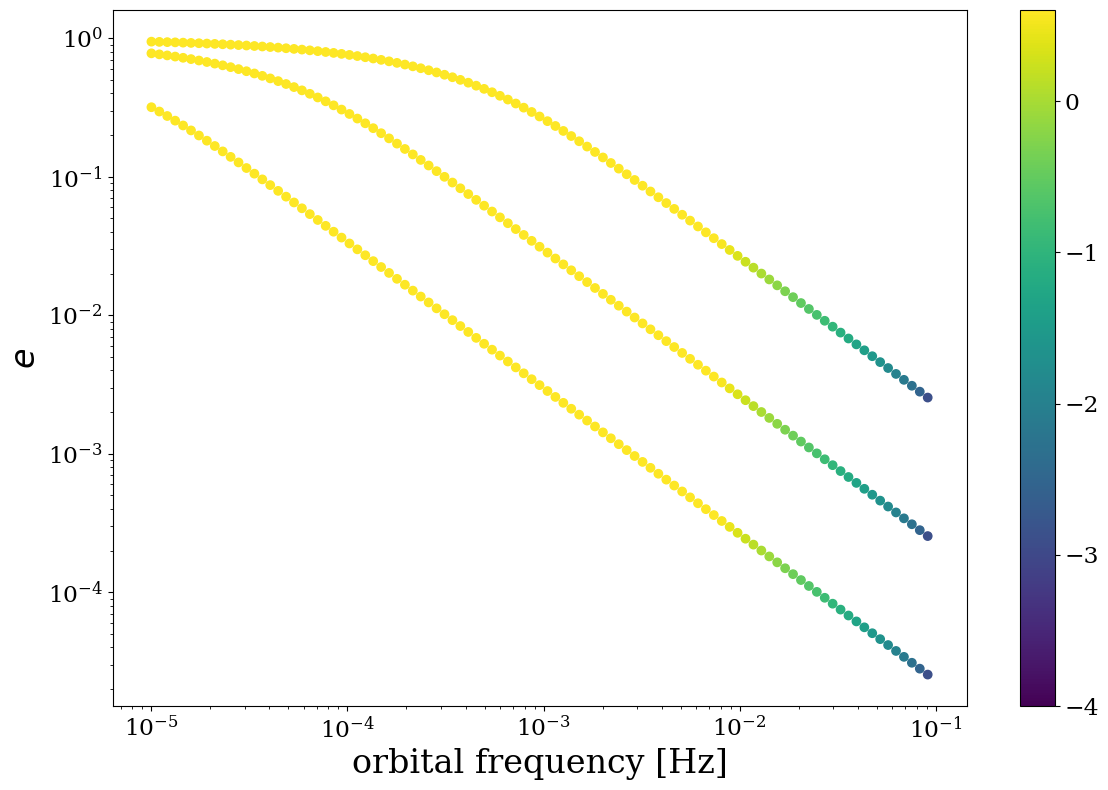

In [11]:
m1 = 40 * u.Msun
m2 = 35 * u.Msun
for e_LIGO in e_LIGO_list:
    dat_out = get_LISA_params(m1, m2, e_LIGO, a_LIGO)
    f_LISA_grid, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol = dat_out
    if e_LISA_grid.all() > 0.0:
        print(np.max(e_LISA_grid))
        plt.scatter(f_LISA_grid, e_LISA_grid, c=np.log10(t_evol.to(u.yr).value), vmin=-4, vmax=np.log10(4))
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$e$')
plt.xlabel('orbital frequency [Hz]')
plt.tight_layout()

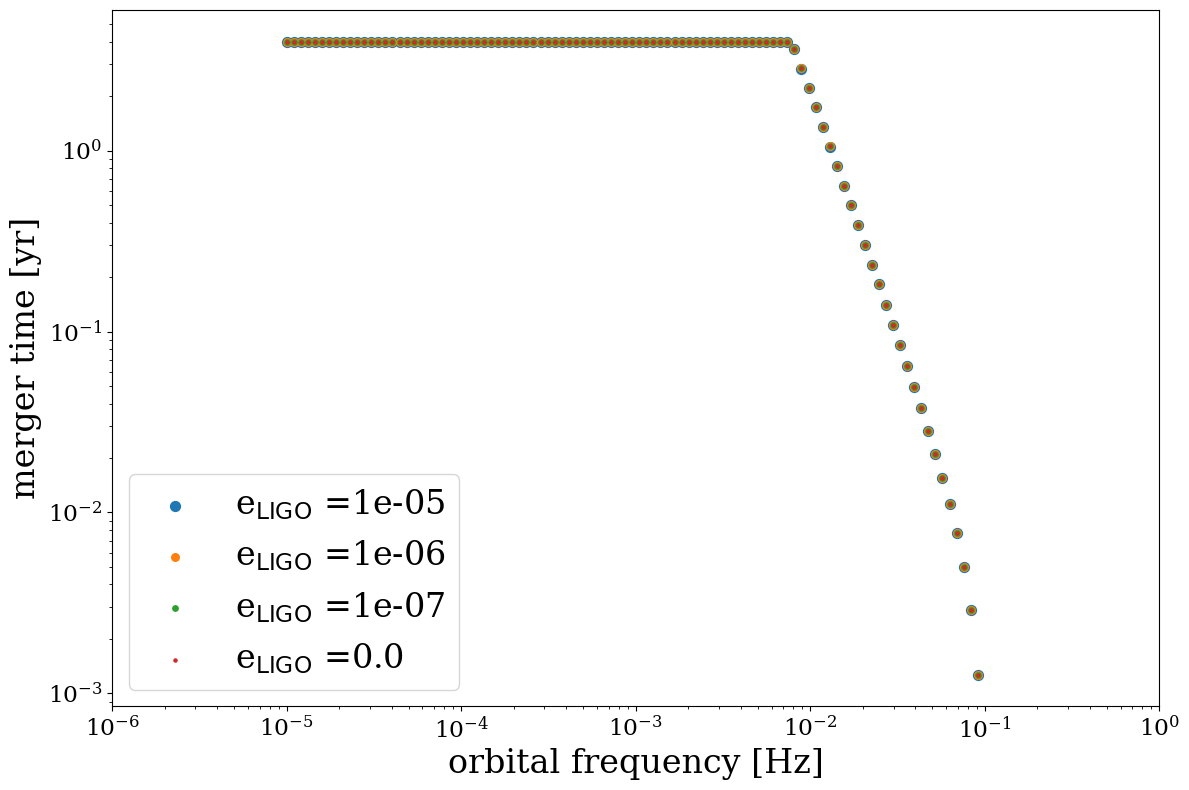

In [12]:
for e_LIGO, ii in zip(e_LIGO_list, [50, 30, 15, 5]):
    dat_out = get_LISA_params(m1, m2, e_LIGO, a_LIGO)
    f_LISA_grid, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol = dat_out
    if e_LISA_grid.all() == 0.0:
        e_LISA_grid = np.ones(len(f_LISA_grid))*1e-10
    plt.scatter(f_LISA_grid, t_evol.to(u.yr), label=r'e$_{\rm LIGO}$ ='+str(e_LIGO), s=ii)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1)
plt.ylabel('merger time [yr]')
plt.xlabel('orbital frequency [Hz]')
plt.tight_layout()

In [13]:
from utils import dTmerger_df

In [14]:
def get_horizon(dat_in):
    m1, m2, ecc, forb, t_evol = dat_in
    s = lw.source.Source(m_1=m_1,
                         m_2=m_2,
                         ecc=e_LISA_grid,
                         f_orb=f_LISA_grid,
                         dist=8 * np.ones(len(e_LISA_grid)) * u.Mpc,
                         interpolate_g=False)
    

    snr = s.get_snr()

    for ii in ind:
        s = lw.source.Source(m_1=m_1[ii],
                             m_2=m_2[ii],
                             ecc=e_LISA_grid[ii],
                             f_orb=f_LISA_grid[ii],
                             dist=8 * u.Mpc,
                             interpolate_g=False)
        snr_ii = s.get_snr(t_obs = t_evol[ii])
        snr[ii] = snr_ii[0]

    d_horizon = np.ones(len(e_LISA_grid))* 8 * u.Mpc * snr/snr_thresh

    return d_horizon


  0%|                                                     | 0/4 [00:00<?, ?it/s]

28


 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.54s/it]

1e-05 4.847521005409918
28


 50%|██████████████████████▌                      | 2/4 [00:04<00:04,  2.43s/it]

1e-06 4.793222967184736
28


 75%|█████████████████████████████████▊           | 3/4 [00:07<00:02,  2.36s/it]

1e-07 4.797212107681383
28


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.34s/it]

0.0 4.797252801688248


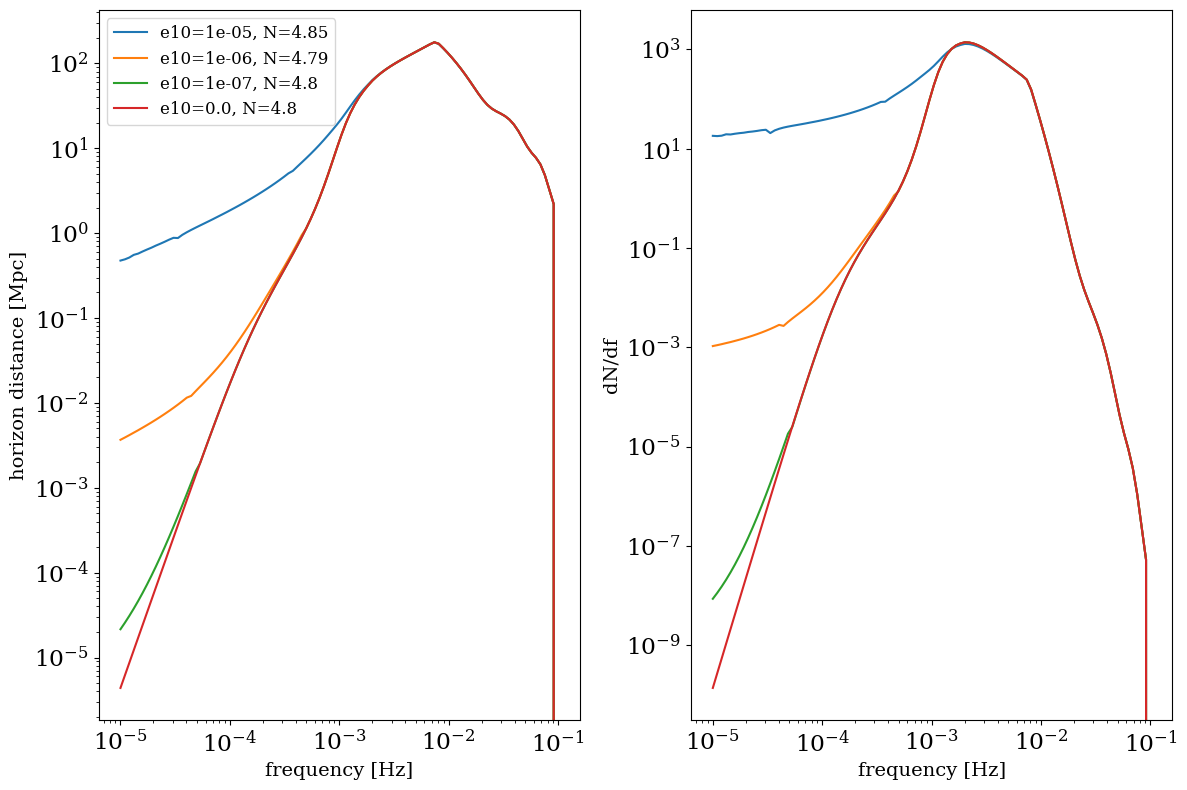

In [15]:
snr_thresh = 12
fig, (ax1, ax2) = plt.subplots(1, 2)
for e_LIGO in tqdm.tqdm(e_LIGO_list):
    dat_out = get_LISA_params(m1, m2, e_LIGO, a_LIGO)
    f_LISA_grid, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol = dat_out
    ind, = np.where(t_evol < 4 * u.yr)

    m_1 = m1*np.ones(len(e_LISA_grid))
    m_2 = m2*np.ones(len(e_LISA_grid))

    s = lw.source.Source(m_1=m_1,
                         m_2=m_2,
                         ecc=e_LISA_grid,
                         f_orb=f_LISA_grid,
                         dist=8 * np.ones(len(e_LISA_grid)) * u.Mpc,
                         interpolate_g=False)
    

    snr = s.get_snr()
    print(len(ind))
    for ii in ind:
        s = lw.source.Source(m_1=m_1[ii],
                             m_2=m_2[ii],
                             ecc=e_LISA_grid[ii],
                             f_orb=f_LISA_grid[ii],
                             dist=8 * u.Mpc,
                             interpolate_g=False)
        snr_ii = s.get_snr(t_obs = t_evol[ii])
        snr[ii] = snr_ii[0]

    d_horizon = np.ones(len(e_LISA_grid))* 8 * u.Mpc * snr/snr_thresh
    

    dT_df = dTmerger_df(m1, m2, f_LISA_grid, e_LISA_grid)
    
    redshift = np.ones(len(d_horizon)) * 1e-8
    redshift[d_horizon > 10 * u.kpc] = z_at_value(Planck18.luminosity_distance, d_horizon[d_horizon > 10 * u.kpc])
    V_c = 4/3 * np.pi * d_horizon**3  

    V_c[d_horizon > 10 * u.kpc] = Planck18.comoving_volume(z=redshift[d_horizon > 10 * u.kpc])

    dNdfdMc = LIGO_rate / f_dot_orb_LISA_grid * V_c.to(u.Gpc**3)
    ax1.plot(f_LISA_grid, d_horizon.to(u.Mpc), label=f'e10={e_LIGO}, N={np.round(trapz(dNdfdMc, -f_LISA_grid), 2)}')
    ax2.plot(f_LISA_grid, dNdfdMc, label=f'e10={e_LIGO}, N={np.round(trapz(dNdfdMc, -f_LISA_grid), 2)}')
    print(e_LIGO, trapz(dNdfdMc, -f_LISA_grid))

# !!!! check the slope for increasing eccentricity
    
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_ylabel('horizon distance [Mpc]', size=14)
ax2.set_ylabel('dN/df', size=14)
ax1.set_xlabel('frequency [Hz]', size=14)
ax2.set_xlabel('frequency [Hz]', size=14)
ax1.legend(prop={'size' : 12})
plt.tight_layout()



In [16]:
f_mask =(f_LISA_grid>0.025*u.Hz) & (f_LISA_grid < 0.045 * u.Hz)
print(d_horizon[f_mask])
print(t_merge_LISA_grid[f_mask].to(u.yr))
#print(e_LISA_grid[f_mask])
print(snr[f_mask])
print(e_LIGO, trapz(dNdfdMc, -f_LISA_grid))

[15.96176354 19.02910268 21.73351476 23.90666255 25.63572257 27.25643747] Mpc
[0.04210367 0.05395901 0.06915254 0.08862418 0.11357855 0.14555946] yr
[23.94264531 28.54365401 32.60027214 35.85999382 38.45358385 40.88465621]
0.0 4.797252801688248


0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9739053620005153
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771484
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.9454582014771485
0.8845623544493307
0.8845623544493307
0.8845623544493307
0.8845623544493307
0.8845623544493308
0.8845623544493307
0.8845623544493307
0.8845623544493307
0.8845623544493307
0.8845623544493307
0.8845623544493307
0.8845623544493308
0.8845623544493307
0.8845623544493307
0.8845623544493307
0.7618091153417036
0.7618091153417035
0.7618091153417035
0.7618091153417036
0.7618091153417036
0.7618091153417035
0.7618091153417036
0.7618091153

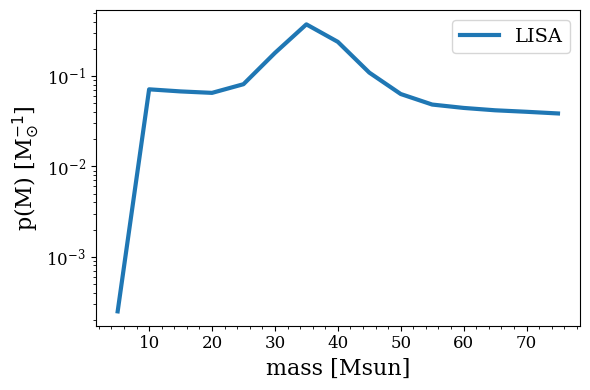

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapz
import paths
import tqdm

def ligo_rate(m1):
    dat = np.array([[3.705799151343708, 0.001087789470121345],
                   [4.384724186704389, 0.00984816875074369],
                   [5.063649222065067, 0.06979974252228799],
                   [5.827439886845831, 0.41173514594201527],
                   [6.506364922206512, 1.3579705933006465],
                   [6.845827439886847, 2.148948034692836],
                   [7.77934936350778, 2.7449738151212433],
                   [8.543140028288544, 2.6218307403757986],
                   [9.561527581329564, 2.0525434471508692],
                   [11.173974540311175, 1.2388629239937763],
                   [12.701555869872706, 0.7828664968878465],
                   [14.398868458274404, 0.4947116747780942],
                   [16.859971711456865, 0.2895969742197884],
                   [19.66053748231967, 0.17748817964452962],
                   [22.206506364922213, 0.12773570001722281],
                   [24.837340876944843, 0.10389898279212807],
                   [27.722772277227726, 0.1087789470121345],
                   [30.183875530410184, 0.13070104796093673],
                   [32.729844413012735, 0.16441704701060267],
                   [34.85148514851486, 0.16695189854274867],
                   [37.397454031117405, 0.12107555776371784],
                   [39.26449787835927, 0.08010405199404155],
                   [41.30127298444131, 0.049851062445855264],
                   [43.592644978783596, 0.029631988560550687],
                   [45.629420084865636, 0.018440841322693136],
                   [48.0905233380481, 0.011832859313068754],
                   [50.891089108910904, 0.007949361111716631],
                   [53.77652050919379, 0.005764973856945108],
                   [57.25601131541727, 0.0043438393396653925],
                   [61.923620933521946, 0.0032730313574784275],
                   [66.67609618104669, 0.0024851284269805634],
                   [70.66478076379069, 0.002068305171949823],
                   [74.82319660537483, 0.0016952583040389245],
                   [78.72701555869875, 0.0013476220436441713],
                   [81.27298444130128, 0.0010389898279212807]])
    
    mass = dat[:,0]
    rate = dat[:,1]
    interp_rate = interp1d(mass, rate)
    
    return interp_rate(m1)

# set up the grids
masses = np.arange(5, 80, 5.0)
m_c = lw.utils.chirp_mass(masses, masses)

# set up bins
delta_m = np.mean(masses[1:] - masses[:-1])/2
mass_bins = np.arange(min(masses) - delta_m, max(masses) + 3 * delta_m, 2*delta_m)
masses = masses * u.Msun
mass_bins = mass_bins * u.Msun
#ecc_bins = [5e-5, 4e-5, 3e-5, 2e-5, 1e-5, 1e-6, 1e-7,1e-8, 0.0]
#ecc_bins = [1e-10]
ecc_bins = np.logspace(-4.2, -9, 10)

## get the meshgrid
#MASS, ECC = np.meshgrid(masses, ecc_bins)
#MC = lw.utils.chirp_mass(MASS, MASS)
#RATE = ligo_rate(MASS.flatten().value)
#RATE = RATE.reshape(MC.shape) * u.Gpc**(-3) * u.yr**(-1) * u.Msun**(-1)
snr_thresh = 7
dNdMc_ecc_2 = []
for e_LIGO in ecc_bins:
    dNdMc = []
    RATE = ligo_rate(masses) * u.Gpc**(-3) * u.hr**(-1) * u.Msun**(-1)
    for m1, m2, LR in zip(masses, masses, RATE):
        a_LIGO = lw.utils.get_a_from_f_orb(m_1=m1, m_2=m2, f_orb = 10 * u.Hz)
        dat_out = get_LISA_params(m1, m2, e_LIGO, a_LIGO)
        #f_LISA_grid*u.Hz, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol
        f_LISA_grid, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol = dat_out
        print(np.max(e_LISA_grid))
        s = source = lw.source.Source(m_1=m1*np.ones(len(e_LISA_grid)),
                                      m_2=m2*np.ones(len(e_LISA_grid)),
                                      ecc=e_LISA_grid,
                                      f_orb=f_LISA_grid,
                                      dist=8 * np.ones(len(e_LISA_grid)) * u.Mpc,
                                      interpolate_g=False)
        snr = s.get_snr()
        d_horizon = np.ones(len(e_LISA_grid))* 8 * u.Mpc * snr/snr_thresh
        horizon_mask = d_horizon > 0.001 * u.Mpc
        horizon_comoving_volume = 4/3 * np.pi * d_horizon**3
        redshift = np.zeros(len(e_LISA_grid))
        redshift[horizon_mask] = z_at_value(Planck18.luminosity_distance, d_horizon[horizon_mask])
        horizon_comoving_volume[horizon_mask] = Planck18.comoving_volume(z=redshift[horizon_mask])
        f_dot_orb_LISA_grid = lw.utils.fn_dot(m_c = lw.utils.chirp_mass(m1, m2), e=e_LISA_grid, n=1, f_orb=f_LISA_grid)
        dNdMc.append(trapz(LR / f_dot_orb_LISA_grid * horizon_comoving_volume.to(u.Gpc**3), -f_LISA_grid).value)
    dNdMc_ecc_2.append(dNdMc)
dNdMc = np.array(dNdMc_ecc_2[0])
        
N_LISA_obs=trapz(dNdMc * u.Msun**(-1), masses)
print(N_LISA_obs)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(masses, dNdMc, lw=3, label=r"LISA")
ax.set_yscale('log')
#ax.plot(masses, ligo_rate(masses)/45, lw=2, label=r"LIGO")
plt.legend(prop={"size":14})
plt.tick_params('both', labelsize=12)
plt.minorticks_on()
ax.set_xlabel('mass [Msun]', size=16)
ax.set_ylabel('p(M) [M$_{\odot}^{-1}$]', size=16)
plt.tight_layout()
plt.savefig(paths.figures / 'fig1.png', facecolor='white', dpi=100)


6.309573444801929e-05 [<Quantity 7.24496333>]
1.8478497974222908e-05 [<Quantity 7.24496333>, <Quantity 9.86478199>]
5.411695265464638e-06 [<Quantity 7.24496333>, <Quantity 9.86478199>, <Quantity 9.73198195>]
1.584893192461111e-06 [<Quantity 7.24496333>, <Quantity 9.86478199>, <Quantity 9.73198195>, <Quantity 9.74628401>]
4.6415888336127725e-07 [<Quantity 7.24496333>, <Quantity 9.86478199>, <Quantity 9.73198195>, <Quantity 9.74628401>, <Quantity 9.75143556>]
1.3593563908785243e-07 [<Quantity 7.24496333>, <Quantity 9.86478199>, <Quantity 9.73198195>, <Quantity 9.74628401>, <Quantity 9.75143556>, <Quantity 9.75188005>]
3.981071705534969e-08 [<Quantity 7.24496333>, <Quantity 9.86478199>, <Quantity 9.73198195>, <Quantity 9.74628401>, <Quantity 9.75143556>, <Quantity 9.75188005>, <Quantity 9.75191818>]
1.165914401179831e-08 [<Quantity 7.24496333>, <Quantity 9.86478199>, <Quantity 9.73198195>, <Quantity 9.74628401>, <Quantity 9.75143556>, <Quantity 9.75188005>, <Quantity 9.75191818>, <Quantit

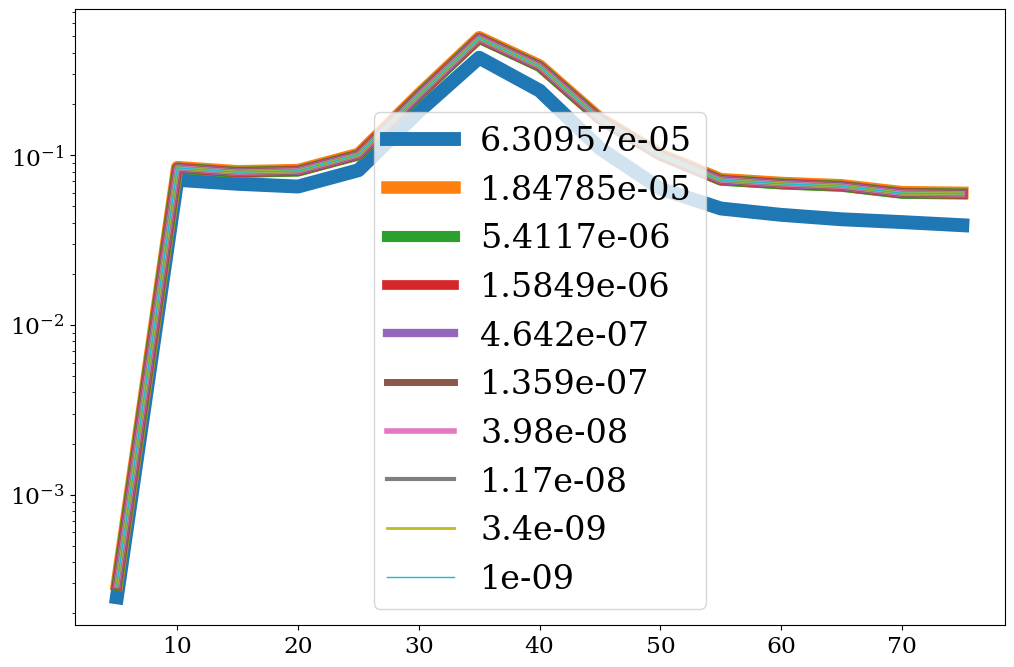

In [44]:
N_LISA_obs = []
for ii in range(len(ecc_bins)):
    dNdMc = np.array(dNdMc_ecc_2[ii])
    plt.plot(masses, dNdMc, label=np.round(ecc_bins[ii], 10), lw=10-ii)
    N_LISA_obs.append(trapz(dNdMc * u.Msun**(-1), masses))

    print(ecc_bins[ii], N_LISA_obs)
plt.yscale('log')
plt.legend()

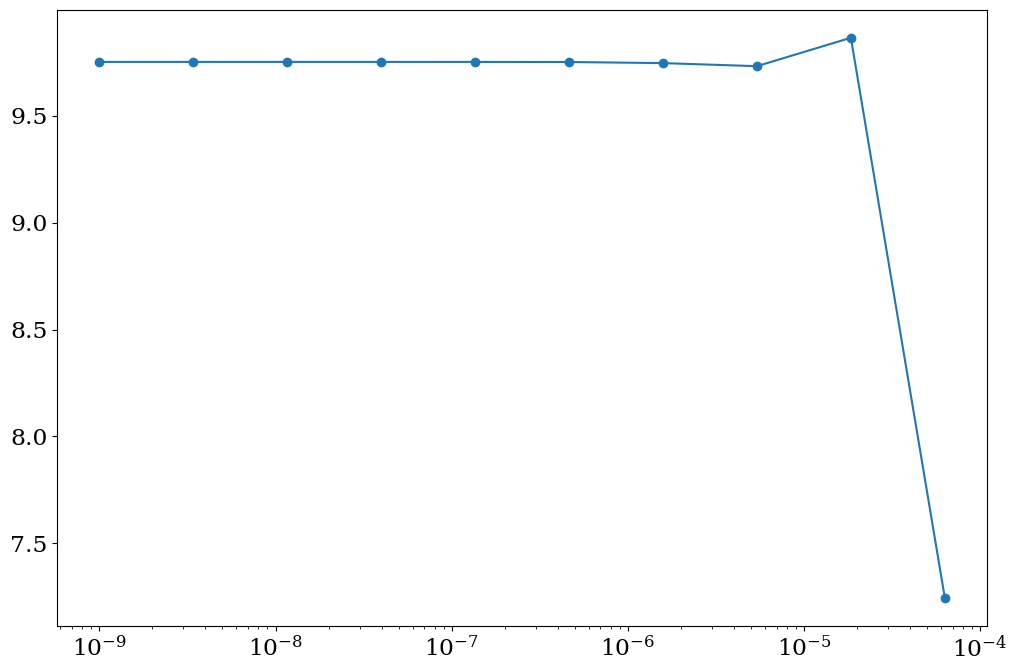

In [48]:
plt.plot(ecc_bins, N_LISA_obs)
plt.scatter(ecc_bins, N_LISA_obs)
plt.xscale('log')